## This notebook as a short experiment with fourier transformation.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier as gbc

In [2]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # I like big figures!

### Build the dataset as recommended in the [github repository's](https://github.com/mmalekzadeh/motion-sense) README:

In [3]:
def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset


In [13]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration", "gravity", "rotationRate"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:6]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']


### Building the dataset:

In [14]:
# os.chdir('A_DeviceMotion_data/A_DeviceMotion_data/')
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 19)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.0,0.0,102.0,188.0,46.0,1.0,1.0


In [15]:
dataset.describe()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
count,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06
mean,-1.760427e-01,-9.866487e-01,-1.492687e-01,-3.910640e-03,4.424380e-02,3.927177e-02,4.213359e-02,7.547222e-01,-1.388248e-01,5.321167e-03,1.458119e-02,1.276031e-02,2.950142e+00,1.147175e+01,7.212055e+01,1.739890e+02,2.883202e+01,5.736535e-01,7.572748e+00
std,1.566652e+00,4.940860e-01,1.544769e+00,3.282090e-01,5.275663e-01,3.762121e-01,3.388300e-01,3.332649e-01,4.283231e-01,1.292916e+00,1.226470e+00,8.080411e-01,1.643905e+00,6.924861e+00,1.598129e+01,8.798617e+00,5.303463e+00,4.945456e-01,3.901147e+00
min,-3.141590e+00,-1.569974e+00,-3.141588e+00,-6.369264e+00,-5.673592e+00,-7.743481e+00,-9.998220e-01,-9.999930e-01,-9.999990e-01,-1.736579e+01,-1.841441e+01,-1.215124e+01,0.000000e+00,0.000000e+00,4.800000e+01,1.610000e+02,1.800000e+01,0.000000e+00,1.000000e+00
25%,-1.480050e+00,-1.358278e+00,-1.277552e+00,-4.751300e-02,-6.213600e-02,-2.361300e-02,-1.725300e-01,5.837930e-01,-3.922410e-01,-2.860300e-01,-1.669860e-01,-9.733300e-02,2.000000e+00,6.000000e+00,6.000000e+01,1.640000e+02,2.500000e+01,0.000000e+00,5.000000e+00
50%,1.222180e-01,-1.181032e+00,-1.356530e-01,8.910000e-04,4.336000e-03,3.433000e-03,1.991400e-02,9.249990e-01,-9.690200e-02,-3.940000e-04,3.250000e-04,1.770000e-04,3.000000e+00,1.200000e+01,7.200000e+01,1.750000e+02,2.800000e+01,1.000000e+00,7.000000e+00
75%,8.763600e-01,-6.233930e-01,8.291430e-01,4.428400e-02,5.176600e-02,1.047770e-01,2.721440e-01,9.775030e-01,8.488200e-02,1.163210e-01,2.312710e-01,1.133280e-01,4.000000e+00,1.800000e+01,7.800000e+01,1.800000e+02,3.100000e+01,1.000000e+00,9.000000e+00
max,3.141579e+00,1.567175e+00,3.141584e+00,7.120793e+00,7.322722e+00,8.125357e+00,9.999980e-01,1.000000e+00,9.813120e-01,1.046806e+01,1.754312e+01,1.143624e+01,5.000000e+00,2.300000e+01,1.020000e+02,1.900000e+02,4.600000e+01,1.000000e+00,1.600000e+01


#### Create labels so we don't get confused.

In [16]:
act_dict = {0: 'dws',
            1: 'ups',
            2: 'wlk',
            3: 'jog',
            4: 'std',
            5: 'sit'}
dataset['label'] =  dataset.act.apply(lambda act: act_dict[act])

## General statistics:

In [17]:
dataset.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
act                   0
id                    0
weight                0
height                0
age                   0
gender                0
trial                 0
label                 0
dtype: int64

In [18]:
dataset.label.value_counts()

wlk    344288
sit    338778
std    306427
ups    157285
jog    134231
dws    131856
Name: label, dtype: int64

### Looks like ups, jog & dws are underrepresented but I think we have enough data to get a decent prediction on all labels.

## Let's take a deeper look at our data!

In [19]:
metrics = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 
            'userAcceleration.z']

#### To get a better feel for the data we'll take a deeper look and try to guess which metrics will be helpful to us.

In [20]:
def plot_data(start_position, number_of_frames, metrics=metrics, fourier=False):
    print(f"Looking at {metrics} for {number_of_frames} from {start_position}")
    for label in dataset.label.unique():
        mini_df = dataset[dataset['label']==label].iloc[start_position:start_position+number_of_frames].reset_index()
        for metric in metrics:
            mini_df[metric].plot(title=label, legend=True)
        plt.show()

### I ran a bunch of these at random points just to see what we are dealing with.

Looking at ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'] for 300 from 82249


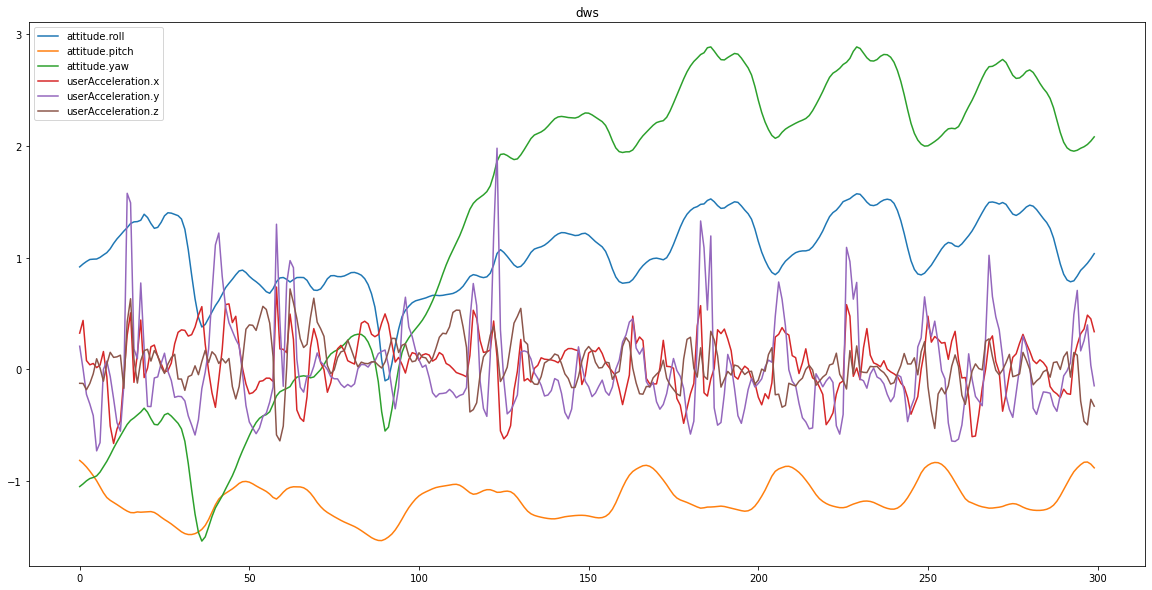

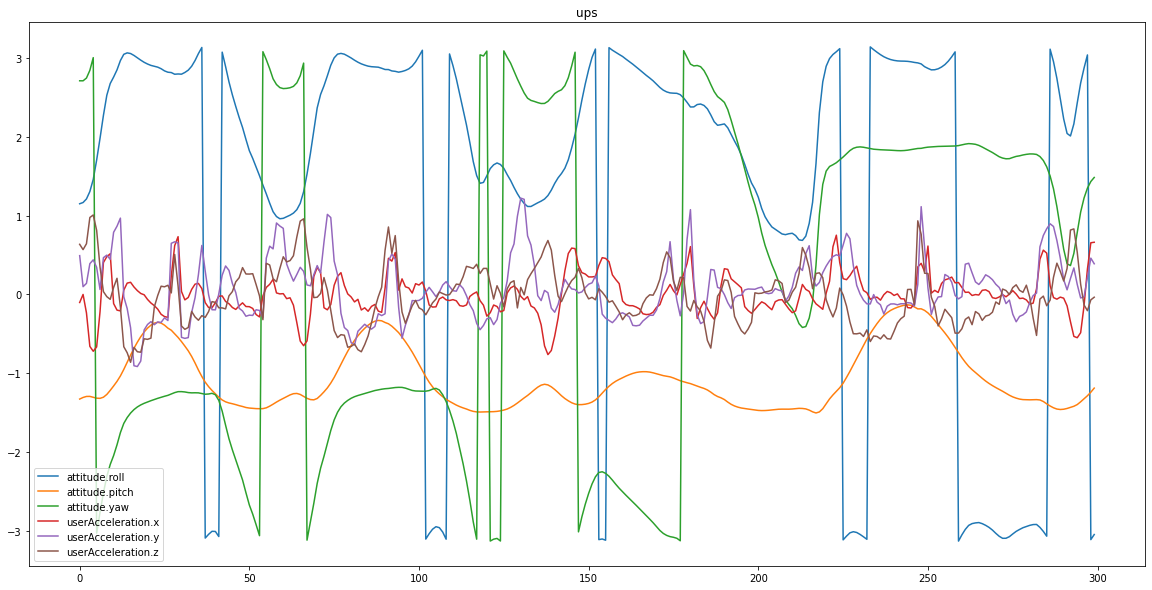

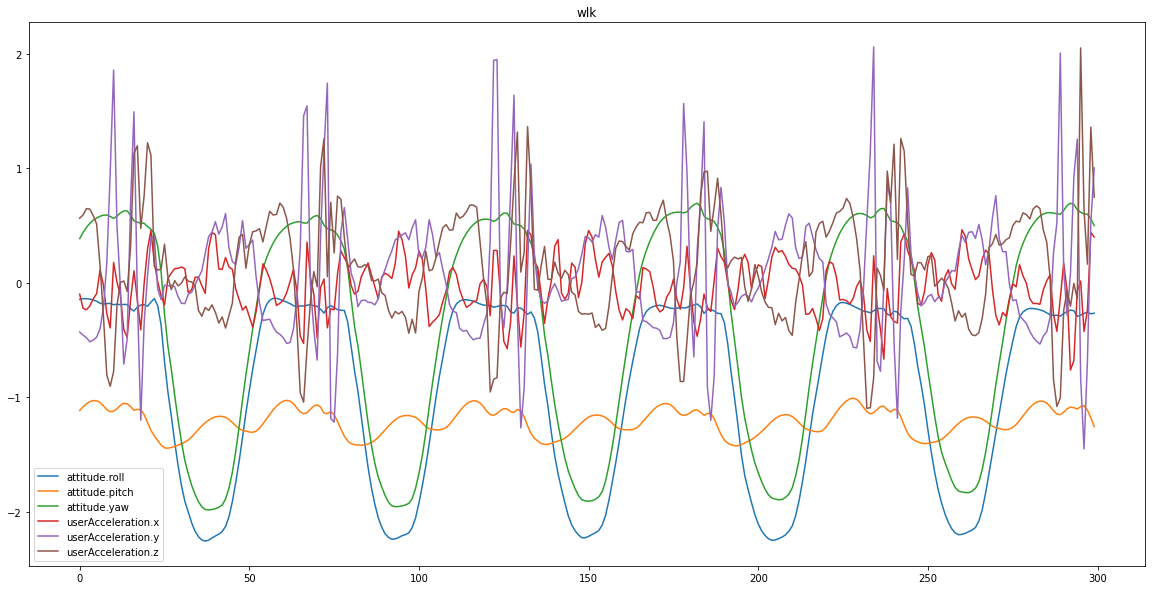

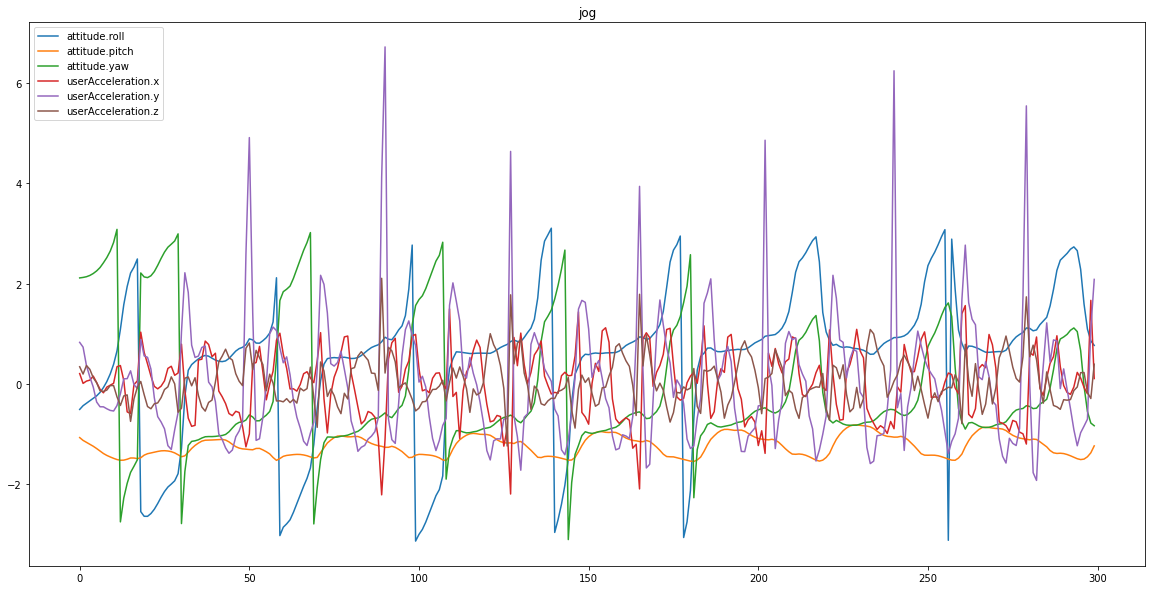

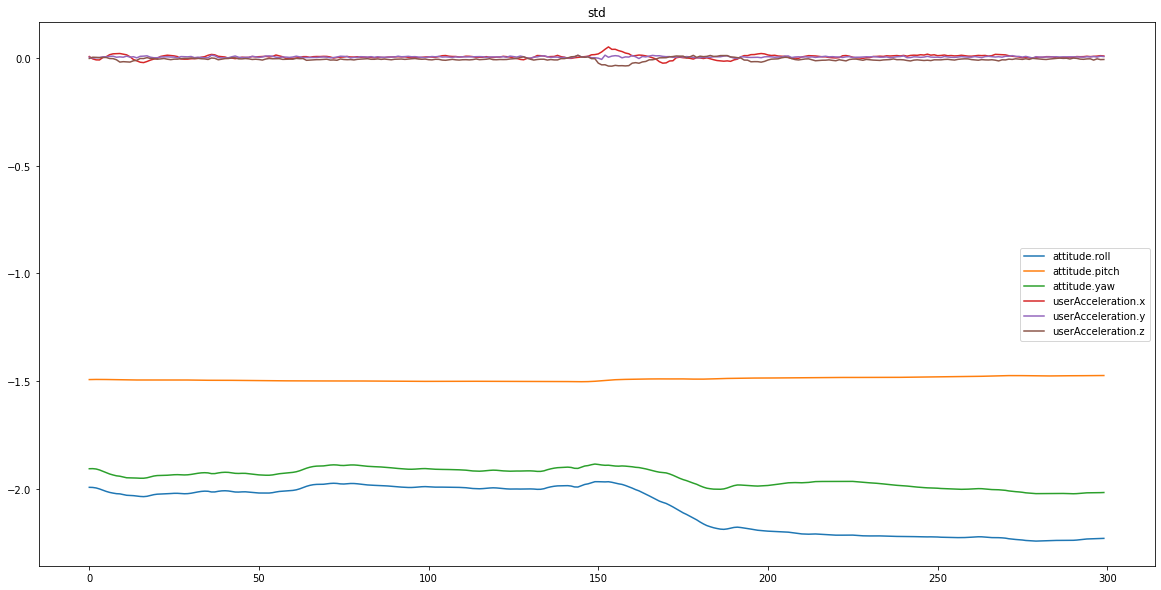

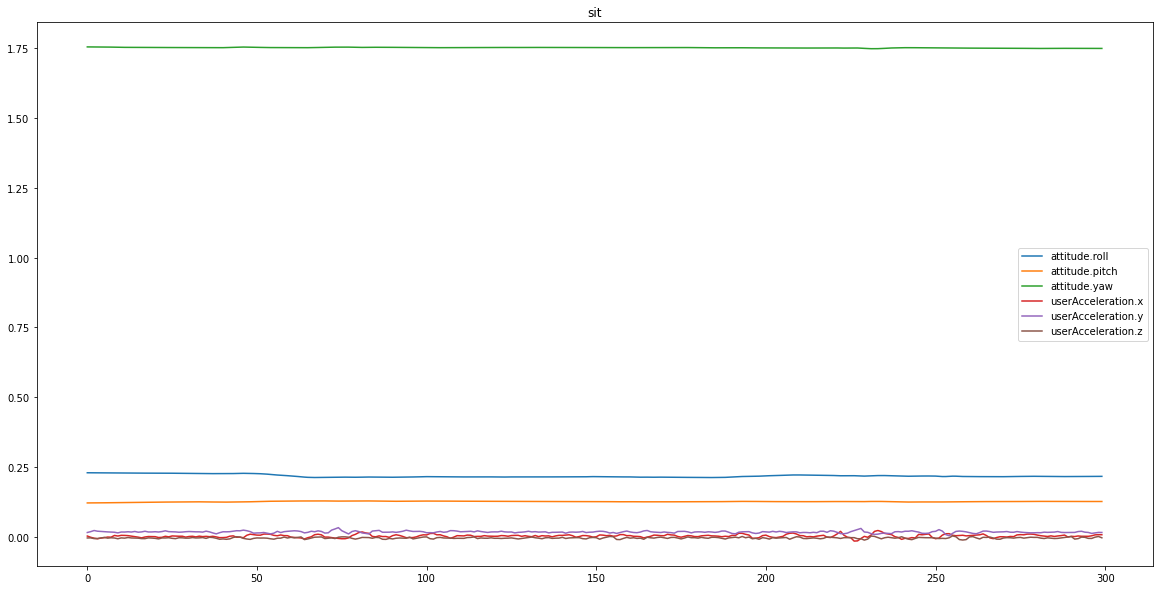

In [21]:
plot_data(np.random.randint(1,130000), 300)

Looking at ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'] for 300 from 12655


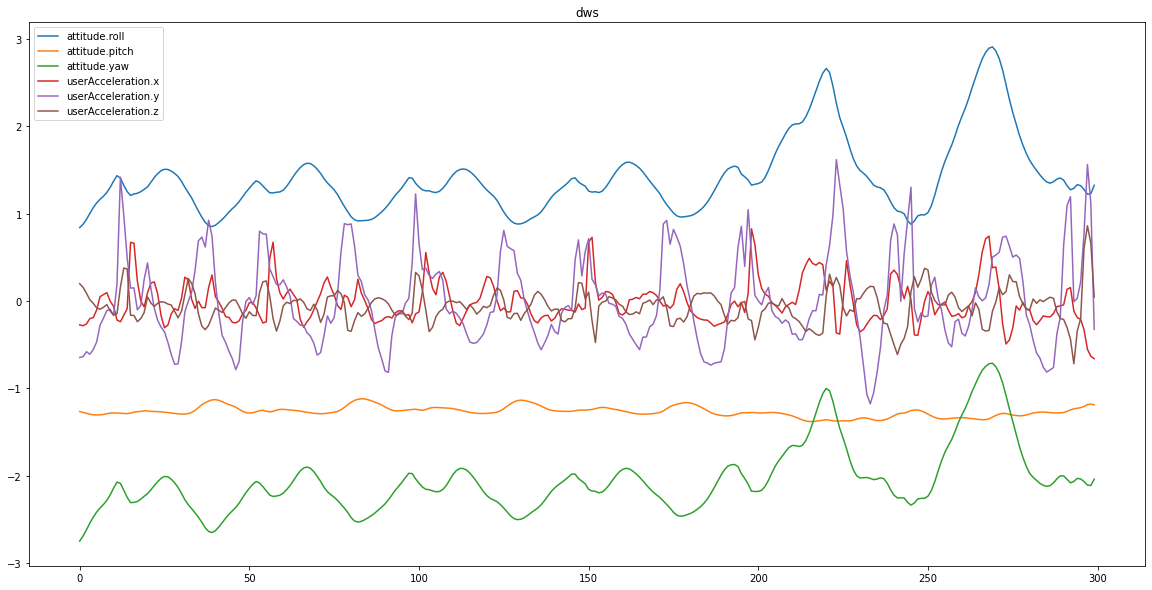

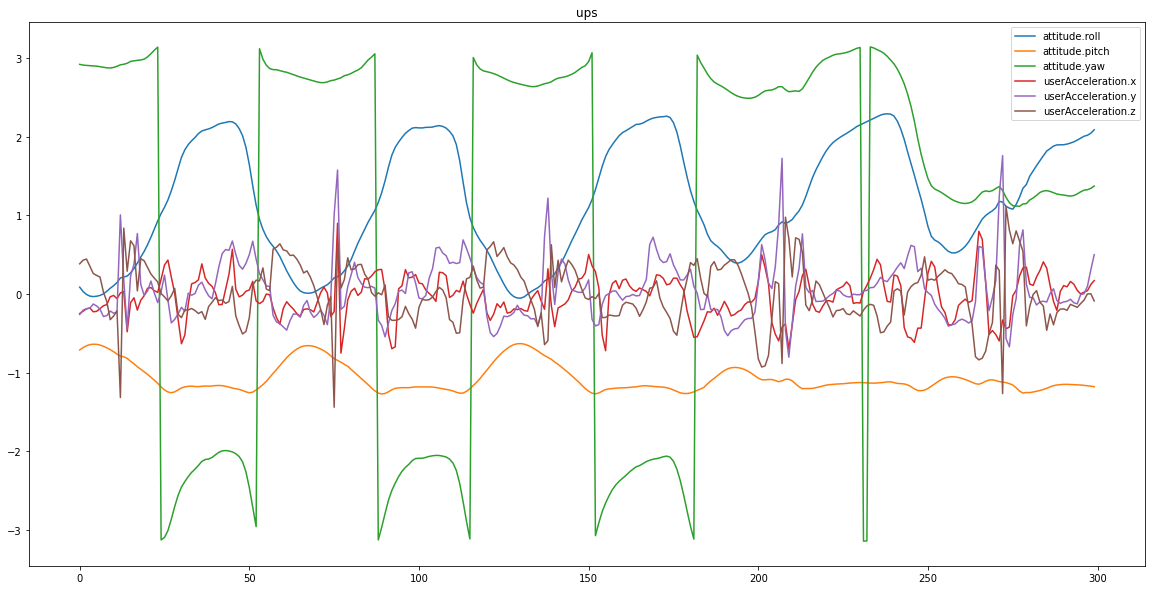

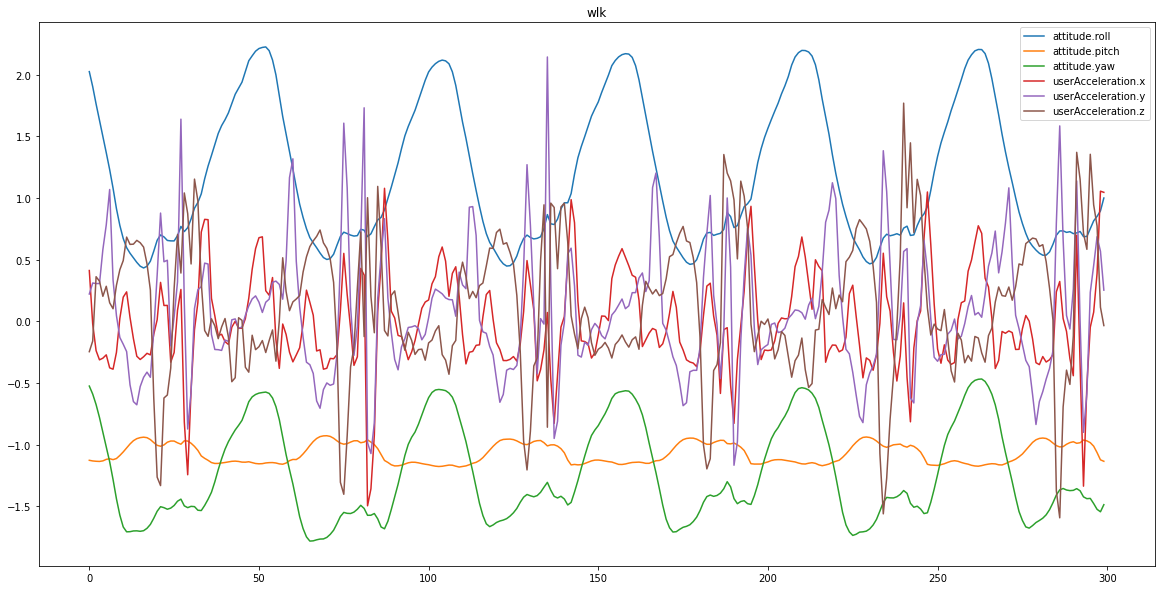

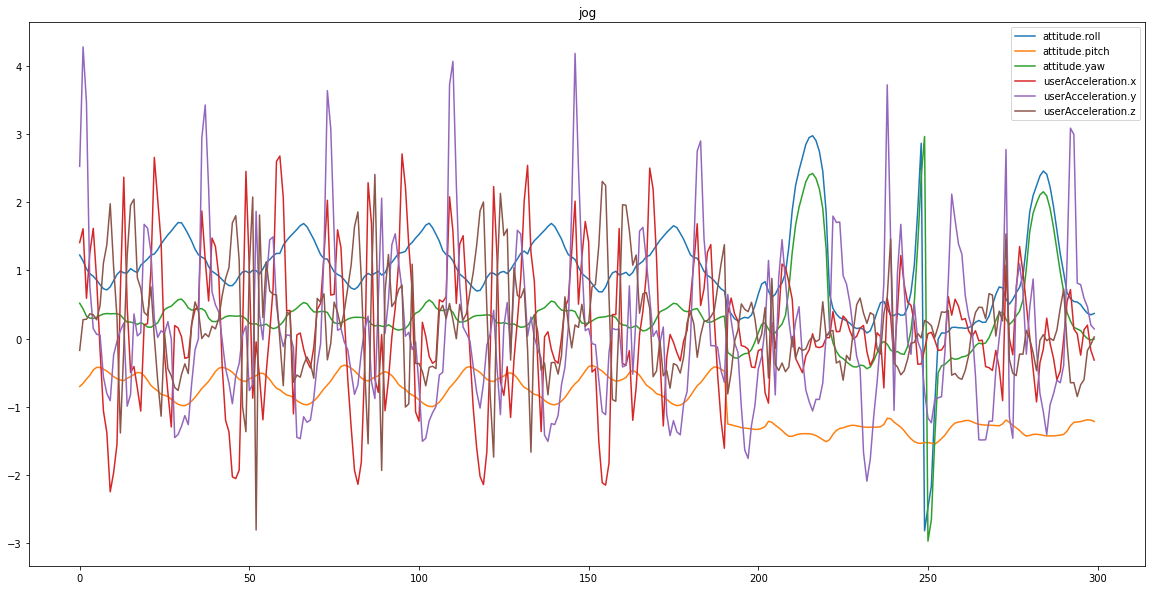

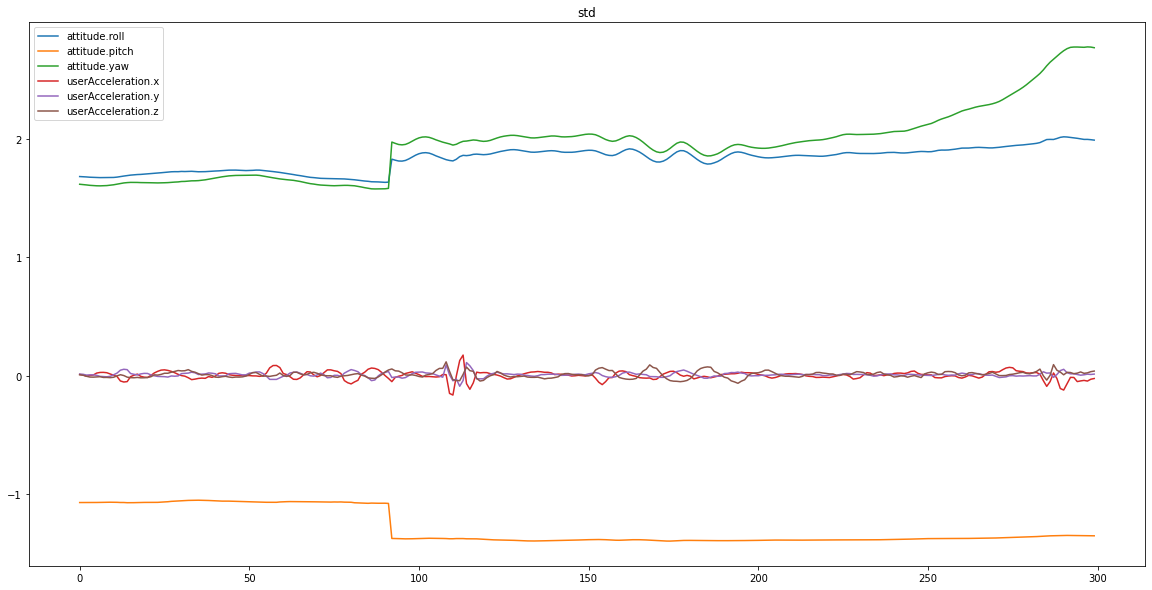

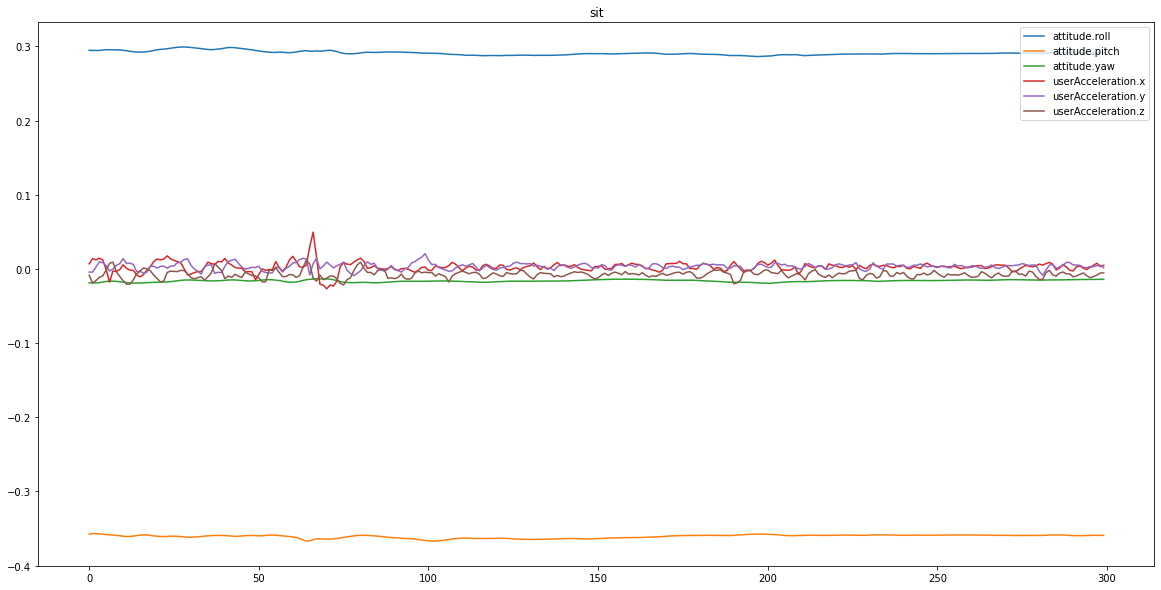

In [22]:
plot_data(np.random.randint(1,130000), 300)

### Some quick conclusions:
 - 300 frames should be enough to get a frequency and amplitude.
 - Acceleration data is noisy!
 - As we would expect, sitting & standing are differet because of their low acceleration amplitude and can be told apart based on pitch.
 - As expected, jogging would be easy to differentiate using frequency.

### Denoising acceleration data:

In [23]:
acceleration_metrics = [metric for metric in metrics if metric.startswith('userAcceler')]
acceleration_metrics

['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

In [24]:
for metric in acceleration_metrics:
    dataset[f'{metric}_ra'] = dataset[metric].rolling(20).median()

In [26]:
avg_acc_metrics = [metric for metric in dataset.columns if metric.endswith('_ra')]
avg_acc_metrics

['userAcceleration.x_ra', 'userAcceleration.y_ra', 'userAcceleration.z_ra']

## Feature Egineering
### Each metric will get 5 features:
 - ### median
 - ### std
 - ### amplitude
 - ### frequency
 - ### phase

In [31]:
dataset.columns

Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'gravity.x', 'gravity.y',
       'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
       'act', 'id', 'weight', 'height', 'age', 'gender', 'trial', 'label',
       'userAcceleration.x_ra', 'userAcceleration.y_ra',
       'userAcceleration.z_ra'],
      dtype='object')

In [32]:
df = dataset.fillna(0, axis=0) # the rolling window made a bunch of nans and it makes our fft unhappy.

### The next block uses loops inside a dataframe which, generally, is a big nono as it is very inefficicent. <br> I chose to not refactor it into something faster (using groupby for instance) because I think it makes things much clearer and more readable and that is our priority in this pedagogical notebook.

In [37]:
metrics = ['userAcceleration.x_ra', 'userAcceleration.y_ra', 'userAcceleration.z_ra', 
           'attitude.roll', 'attitude.pitch', 'attitude.yaw']

def build_features(data=df, number_of_frames=300, metrics=metrics):
    instances = pd.DataFrame() # this is where our features and labels will end up.
    instance = 0
    data.fillna(method='bfill')
    for label in data.label.unique():
        print(f"Building features for {label}...")
        start_position=0
        label_df = data[data['label']==label]
        while len(label_df) > start_position+number_of_frames:
            for metric in metrics:
                instance_df = label_df.iloc[start_position:start_position+number_of_frames].reset_index()
                instances.loc[instance, 'label'] = label
                instances.loc[instance, f'median_{metric}'] = instance_df[metric].median()
                instances.loc[instance, f'std_{metric}'] = instance_df[metric].std()
                fourier = np.fft.rfft(instance_df[metric])[1:]
                amplitude = max(np.abs(fourier))
                frequency = np.where(np.abs(fourier)==amplitude)[0][0]
                instances.loc[instance, f'amplitude_{metric}'] = amplitude
                instances.loc[instance, f'frequency_{metric}'] = frequency
                instances.loc[instance, f'phase_{metric}'] = np.angle(fourier)[frequency]
            instance = instance + 1
            start_position = start_position + number_of_frames
    return instances

In [38]:
instances = build_features()

Building features for dws...
Building features for ups...
Building features for wlk...
Building features for jog...
Building features for std...
Building features for sit...


### Sanity checks:

In [39]:
instances.head()

,label,median_userAcceleration.x_ra,std_userAcceleration.x_ra,amplitude_userAcceleration.x_ra,frequency_userAcceleration.x_ra,phase_userAcceleration.x_ra,median_userAcceleration.y_ra,std_userAcceleration.y_ra,amplitude_userAcceleration.y_ra,frequency_userAcceleration.y_ra,...,median_attitude.pitch,std_attitude.pitch,amplitude_attitude.pitch,frequency_attitude.pitch,phase_attitude.pitch,median_attitude.yaw,std_attitude.yaw,amplitude_attitude.yaw,frequency_attitude.yaw,phase_attitude.yaw
0,dws,0.041375,0.130866,13.285552,5.0,-0.284693,-0.073436,0.082114,11.062952,0.0,...,-0.823133,0.095911,11.252534,0.0,-1.001653,-2.294799,2.057015,366.369855,0.0,-1.716210
1,dws,0.035450,0.162516,22.341550,0.0,-1.984861,-0.043573,0.113359,16.002861,0.0,...,-0.773683,0.185634,34.839413,0.0,1.326130,-0.279123,1.325466,256.579775,0.0,1.741231
2,dws,-0.000894,0.122407,14.875868,0.0,1.797379,0.054485,0.129477,23.299884,0.0,...,-0.581228,0.118727,19.694635,0.0,-1.484126,0.758512,1.924711,290.747374,0.0,-2.492926
3,dws,0.063287,0.130100,12.793933,0.0,2.689229,-0.065783,0.100641,9.320125,5.0,...,-0.667099,0.117470,15.422492,0.0,0.464910,-2.367177,1.286902,232.842871,0.0,1.062918
4,dws,0.009222,0.113955,9.741411,5.0,-2.378215,0.017004,0.091497,13.406031,0.0,...,-0.546897,0.110786,19.110820,0.0,-1.503740,0.788550,1.836304,247.194554,0.0,-2.693482


In [40]:
len(instances)

4707

In [41]:
instances.label.value_counts()

wlk    1147
sit    1129
std    1021
ups     524
jog     447
dws     439
Name: label, dtype: int64

#### We expect median pitch to be a way of differentiating sitting:

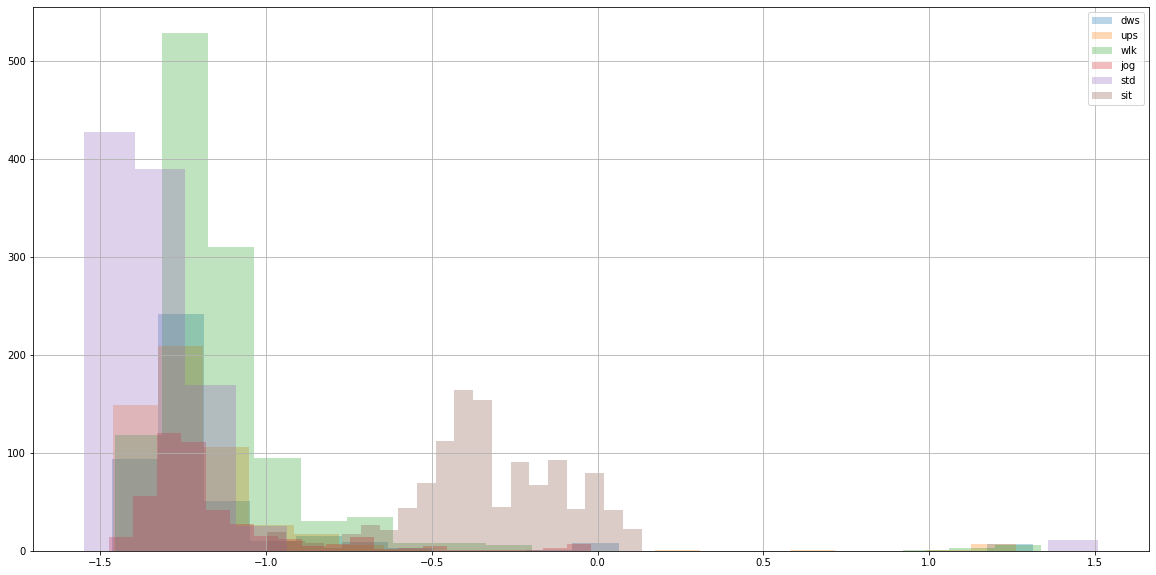

In [42]:
for label in instances.label.unique():
    for feature in ['median_attitude.pitch']:
        instances[instances.label==label][feature].hist(alpha=0.3, label=label, bins=20)
plt.legend()
plt.show()

#### Yay!

#### We also expect frequency to be a way of setting the joggers apart:

In [43]:
frequencies = [feature for feature in instances.columns if feature.startswith('frequency')]
frequencies

['frequency_userAcceleration.x_ra',
 'frequency_userAcceleration.y_ra',
 'frequency_userAcceleration.z_ra',
 'frequency_attitude.roll',
 'frequency_attitude.pitch',
 'frequency_attitude.yaw']

In [44]:
instances['med_freq'] = instances[frequencies].median(axis=1)

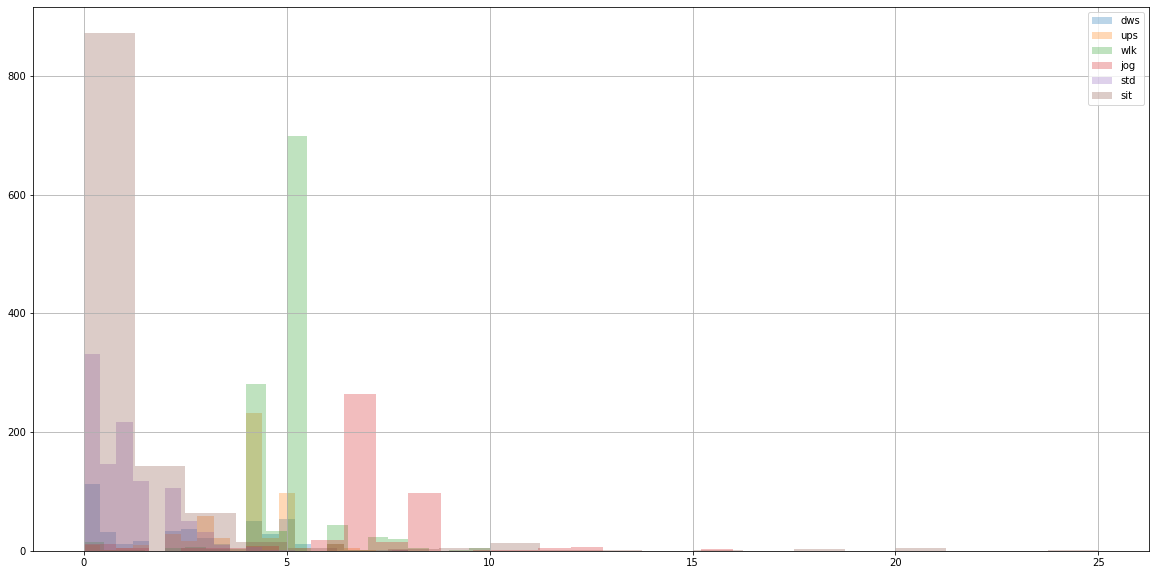

In [45]:
for label in instances.label.unique():
    instances[instances.label==label]['med_freq'].hist(alpha=0.3, label=label, bins=20)
plt.legend()
plt.show()

#### Tada!

## Let's just shove it in a decision tree and see what happens:

In [27]:
def plot_feature_importance(model, feature_names):
    feature_importances = model.feature_importances_
    idxSorted = np.argsort(feature_importances)[-10:]
    barPos = np.arange(idxSorted.shape[0]) + .5
    plt.barh(barPos, feature_importances[idxSorted], align='center')
    plt.yticks(barPos, feature_names[idxSorted])
    plt.xlabel('Feature Importance')
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
    plt.show()

MMC: 0.967
MMC: 0.946
MMC: 0.954
MMC: 0.960
MMC: 0.943
Mean MMC: 0.954
Std of MMCs: 0.0087
These are the plots of the last test so we could get an idea of what it looks like:


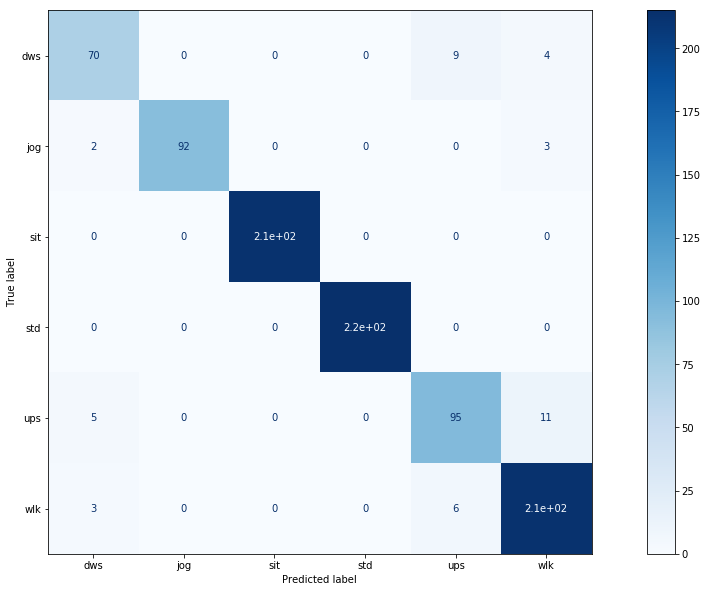

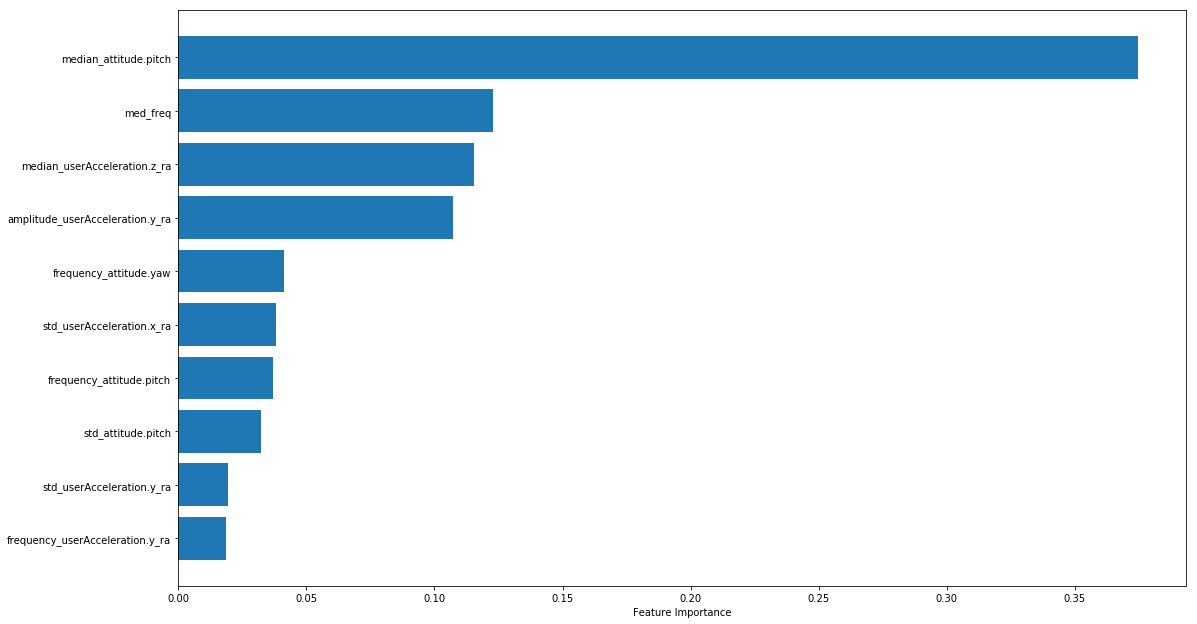

In [28]:
y = instances.label
X = instances.drop('label', axis=1)
kf = KFold(n_splits=5, shuffle=True)
gbc_model = gbc()
MMC = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    gbc_model.fit(X_train, y_train)
    y_pred = gbc_model.predict(X_test)
    print(f"MMC: {matthews_corrcoef(y_test, y_pred):.3f}")
    MMC.append(matthews_corrcoef(y_test, y_pred))
print(f"Mean MMC: {np.mean(MMC):.3f}")
print(f"Std of MMCs: {np.std(MMC):.4f}")
print("These are the plots of the last test so we could get an idea of what it looks like:")
plot_confusion_matrix(gbc_model, X=X_test, y_true=y_test, labels=gbc_model.classes_, cmap='Blues')
plt.show()
plot_feature_importance(gbc_model, X_test.columns)

### Bam!
Results are pretty good, very stable and comparable with different notebooks here using DL techniques.

### I spent quite a bit of time debugging that fourier function up there.. so I wonder how much did it help for the overall score?

In [29]:
no_fft_features = [feature for feature in instances.columns  if feature.startswith('median') or feature.startswith('std')]
no_fft_features

['median_userAcceleration.x_ra',
 'std_userAcceleration.x_ra',
 'median_userAcceleration.y_ra',
 'std_userAcceleration.y_ra',
 'median_userAcceleration.z_ra',
 'std_userAcceleration.z_ra',
 'median_attitude.roll',
 'std_attitude.roll',
 'median_attitude.pitch',
 'std_attitude.pitch',
 'median_attitude.yaw',
 'std_attitude.yaw']

MMC: 0.8976911507055259


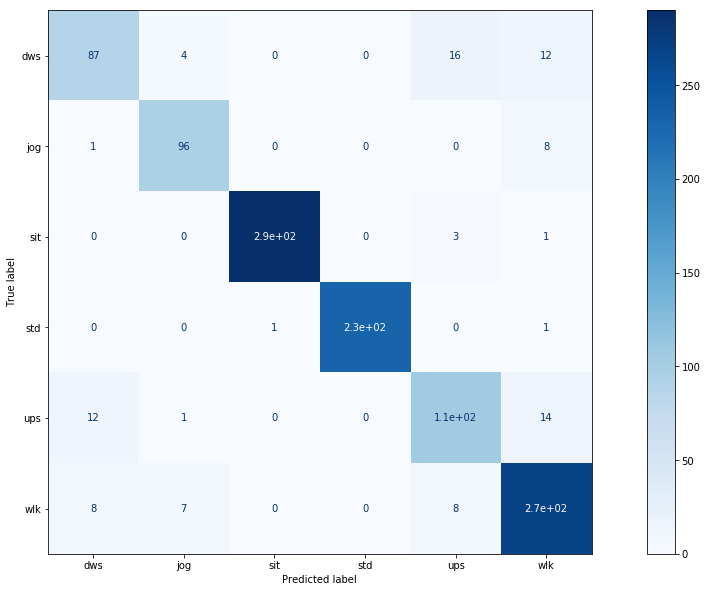

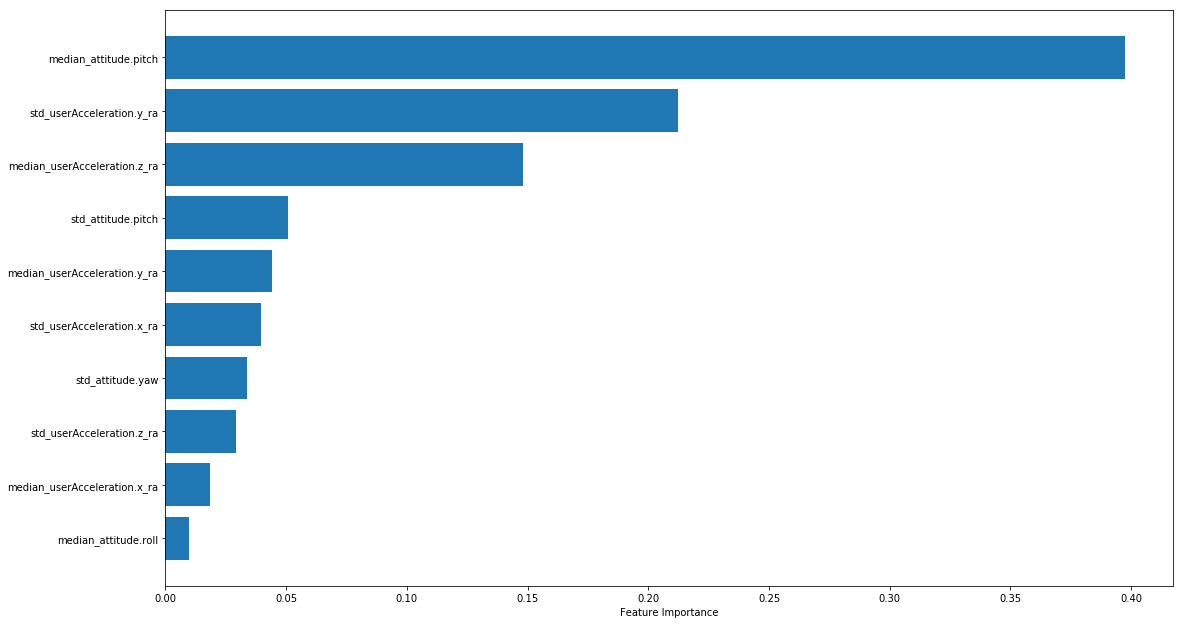

In [30]:
y = instances.label
features = no_fft_features
X = instances[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
gbc_model = gbc()
gbc_model.fit(X_train, y_train)
y_pred = gbc_model.predict(X_test)
print(f"MMC: {matthews_corrcoef(y_test, y_pred)}")
plot_confusion_matrix(gbc_model, X=X_test, y_true=y_test, labels=gbc_model.classes_, cmap='Blues')
plt.show()
plot_feature_importance(gbc_model, X_test.columns)

So the Fourier transform made a difference but even without it the algorithm works surprisingly well...

## What can be done to improve predictions:
Lots! <br>
- Hyperparameter optimization - I just took the default values in the first tree classifier I could think of...
- Different prediction model - Another tree or a different classifier.
- More features - for instance - Phase!
- More preprocessing so a better moving avg or aligning the data somehow.
- Cut the data into smaller pieces (less frames per instance) might improve prediction but, we would need to think hard about how to measure the improvement.